In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from numpy import *

from IPython.display import HTML
from matplotlib import animation

import healpy as hp
from mayavi import mlab

plt.rc('text', usetex=False)
mpl.rcParams['legend.fontsize'] = 12


# The antenna pattern of a GW detector

## The simple case - one arm
Let's see if we can get the response of a interferometer arm to a GW. Larson & Hellings (2000) show that for one arm, the response is $\cos(2\chi) (1-\cos^2\psi)=
\cos(2\chi)\sin^2\psi$ where $\psi$ is the angle between the propagation vector $\vec k$ of the GW and the IF arm, $\chi$ is the polarisation angle.

If we put the arm on the $x$-axis and parametrise the $\vec k$-vector by the usual spherical coordiantes $\vec k = -\hat e_r=-(\sin\theta\cos\phi, \sin\theta\sin\phi,\cos\theta)$ then $\cos\psi=-\sin\theta\cos\phi$ and the response is then
\begin{align}
\cos(2\chi)\bigl(1-\sin^2\theta\cos^2\phi\bigr)
\end{align}


Here we take the case of a polarisation angle of $\chi=0$ as this gives the maximal signal in all cases. Note, though, that the response is moudlated with $\cos(2\chi)$ due to the quadrupolar nature of the gravitational wave.

### Definition of a helper function: spherical plot

Here we define a function that makes a spherical plot, i.e plots a function $R(\theta,\phi)$ in spherical coordinates. We also define a function that transforms the 'canonical' coordinates into the 'orbit' coordinates, so that we can easily plot the antenna pattern as it goes around on the orbit.

In [4]:
def toOrbit(X,Y,Z, psi=0, a=0, xi=0):
    '''
    Converts 'canonical coordinates' (i.e. centered on the origin and along the standard directions)
    into 'orbit coordinates'
    
    Parameters
    ----------
    
    X,Y,Z  : canonical coordinates
    psi    : internal rotation of the constellation
    a      : orbital radius
    xi     : position on the orbit
    
    For LISA, psi=-xi, as the constellation counterrotates
    '''
    
    xp = (cos(xi)*(2*a - Z + sqrt(3)*X*cos(psi) - sqrt(3)*Y*sin(psi)))/2. - (Y*cos(psi) + X*sin(psi))*sin(xi)
    yp = cos(xi)*(Y*cos(psi) + X*sin(psi)) + ((2*a - Z + sqrt(3)*X*cos(psi) - sqrt(3)*Y*sin(psi))*sin(xi))/2.    
    zp = (sqrt(3)*Z + X*cos(psi) - Y*sin(psi))/2.
    
    return xp,yp,zp
        
def sphericalplot(r, theta, phi, axx=0, add=True, plain=False, fig=0, psi=0, a=0, xi=0, kind='surface', **kwargs):
    '''
    Plots a function in spherical coordinates

    Parameters
    ----------
    r  : function
         The function to be plotted. Needs to be vectorized. 
         This happens automagically if all internal functions are from numpy
    theta: vector of theta-values. The convention is 0==North Pole, Pi=South Pole.
    phi: vector of phi-values (0... 2*pi)

    **kwargs
        The keyword arguments are passed through to plot_surface

    '''
    THETA, PHI = meshgrid(theta, phi)
    R = r(THETA, PHI)
    X = R * sin(THETA) * cos(PHI)
    Y = R * sin(THETA) * sin(PHI)
    Z = R * cos(THETA) 
       
    if plain:
        xp=X
        yp=Y
        zp=Z
    else:
        xp,yp,zp = toOrbit(X,Y,Z,psi=psi,a=a,xi=xi)
        
    # matplotlib
    if axx==0:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.gca(projection='3d')
    else:
        ax=axx 
        if not add: 
            
            ax.collections = []
            
    if kind=='surface':
        plot = ax.plot_surface(xp, yp, zp, **kwargs)
    elif kind=='wireframe':
        plot = ax.plot_wireframe(xp, yp, zp, **kwargs)
    else:
        print('"kind" accepts only "surface" or "wireframe"')
        
    return plot, ax

### A simple example

Let's start with the "antenna pattern" of a single arm. This is not particularly useful, but demonstrates the principles

(-1.01, 1.01)

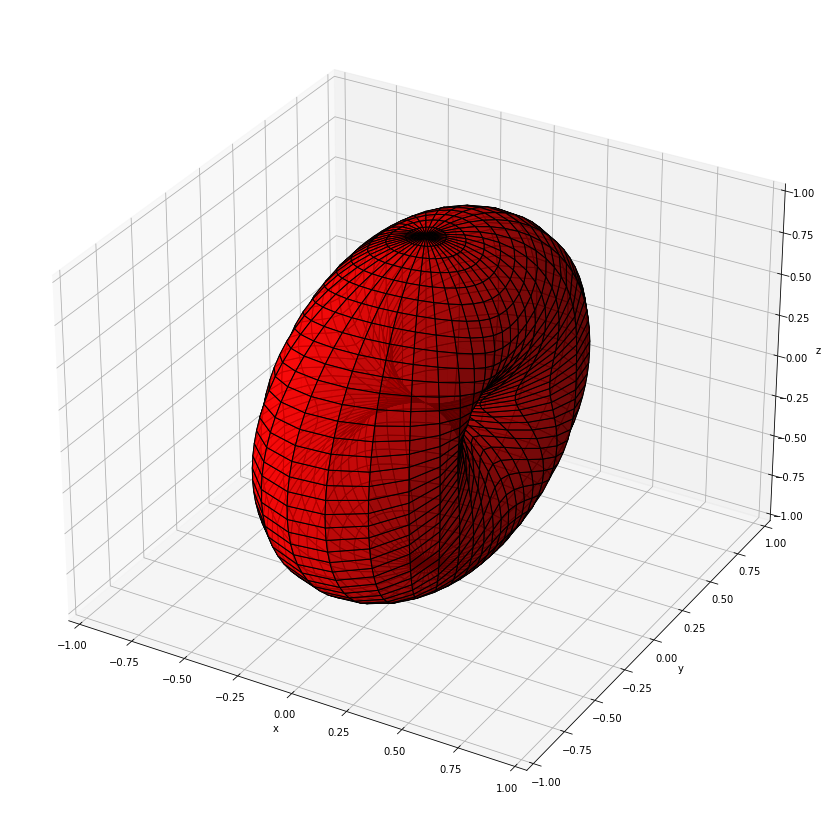

In [5]:
theta, phi = np.linspace(0, np.pi, 40), np.linspace(0, 2*np.pi, 40)


def onearm(theta, phi):
    return 1-(sin(theta)*cos(phi))**2


plot,ax = sphericalplot(onearm, theta, phi,plain=True,
                         rstride=1, cstride=1,
                         color='r', edgecolor='k', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.01, 1.01)
ax.set_ylim(-1.01, 1.01)


## The more realistic case:  two-arm interferometer

In the case of two arms, we define the response of the interferometer as the \emph{difference} of the responses of the two arms. This is inspired by the way the signal forms in a Michelson interferometer, where the output is also given bythe difference of the phase shifts in the two arms. In principle, this is an assumption that need to be substantiated and a more detailed investigation would need to look at a general linear combination of the phase shifts coming from each arm, but for the moment, we stay with the simple case of the difference of the signals. So we have to evaluate
\begin{align}
\cos(2\chi_1)\bigl(1-\cos^2\psi_1)-\cos(2\chi_2)\bigl(1-\cos^2\psi_2)
\end{align}

If we have two arms, we also have two polarisation angels $\chi_1$ and $\chi_2$, as each arm "sees" the fixed polarisation of the source under a different angle, as well as two angles $\psi_1$ and $\psi_2$. If we put the $x$-axis now at the bisector of the two arms and keep the arms in the $x-y$ plane, we can write the unit vectors pointiong along the arms as 
\begin{align}
  \hat\ell_1 &= (\cos\alpha, \sin\alpha,0)\\
  \hat\ell_2 &= (\cos\alpha, -\sin\alpha,0)
\end{align}
where $2\alpha$ is the angle between the arms. So it follows that
\begin{align}
  \cos\psi_{1,2} &= \hat\ell_{1,2} \vec k \\
  &= \sin\theta\left(\cos\phi\cos\alpha \pm \sin\phi\sin\alpha\right)\\
  &= \sin\theta\cos(\phi\mp\alpha)
  \end{align}
which gives us half of the terms that we need for the signal.
 
### Defining the polarisation angles 
The polarisation angles are a bit more complicated. First, we need to specify what we actually mean. Paraphrasing Larson \& Hellings(2000):

> The polarization angles, $\chi_i$, are measured from the line where the plane $P_i$ formed by the $i$-th arm and the propagation vector $\vec k$ intersects the plane $P_p$ containing the principal polarization vector, i.e. the plane normal to the propagation vector.

This definition allows us to evaluate the polarisation angles $\chi_{1,2}$, as seen by the respective arms.

As above, we have $\vec k=-\hat e_r$, so it is natural to parametrize the plane $P_p$ that contains the polarisation vectors and that is orthogonal to $\vec k$ with the two other canonical base vectors $\hat e_\phi$ and $\hat e_\theta$ as $\{\hat e_r, \hat e_\theta, \hat e_\phi\}$ forms a right-handed base system, i.e. $\hat e_r \times \hat e_\theta = \hat e_\phi$. 

The plane $P_i$ formed by the propagation vector $\vec k$ and the arm vector $\vec\ell$ has $\hat e_r$ and $\hat \ell$ as base vectors (for simplicity we leave out the index here), although they are in general not orthorgonal. We are now looking for the intersection of those planes, preferably described in the base $(\hat e_\phi, \hat e_\theta)$ as that makes it easy to determine $\chi$. We write the directional vector of the line of intersection as $\hat u = \cos\beta \,\hat e_\theta + \sin\beta\,\hat e_\phi$, introducing the parameter $\beta$. As $\hat u$ must also be contained in the $(\vec k, \vec\ell)$-plane, any vector normal to that plane must also be normal to $\hat u$, so
\begin{equation}
(\vec k\times\hat\ell)\hat u=0
\end{equation}
must hold. As $\vec k=-\hat e_r$ we can write
\begin{align}
(\vec k\times\hat\ell)\hat u &= (\hat e_r \times \hat u)\hat\ell 
\end{align}
and by substituting $\hat u$ we get 
\begin{align}
(\hat e_r \times \hat u)\hat\ell &= (\cos\beta\,\hat e_r\times\hat e_\theta + \sin\beta\,\hat e_r\times\hat e_\phi)\hat\ell\\
&= (\cos\beta \,\hat e_\phi - \sin\beta\,\hat e_\theta)\hat\ell =0
\end{align}
As $\hat e_\phi = (-\sin\phi, \cos\phi,0)$ and $\hat e_\theta = (\cos\theta\cos\phi, \cos\theta\sin\phi, -\sin\theta)$ we finally get

\begin{equation}
\sin \beta  \cos \theta  \cos (\alpha -\phi ) -\cos \beta  \sin (\alpha -\phi )= 0
\end{equation}

Writing this as 
\begin{equation}
\sin(\beta-\Phi) = \sin\beta \cos\Phi - \cos\beta\sin\Phi = 0
\end{equation}
which requires $\beta = \Phi$ and reading off $\cos\Phi$ and $\sin\Phi$ from above, we get
\begin{equation}
\tan\beta = \tan\Phi= \frac{\tan(\alpha -\phi)}{\cos\theta}
\end{equation}

As $\beta$ is the angle of the intersection of the two planes with respect to the $\phi$-axis, the actual $\chi$ can be simply calculated as  $\chi=\chi_0-\beta$ where $\chi_0$ is the polarisation angle defined in the source system, i.e. with respect to the $\phi$-axis. The factor $\cos(2\chi)$ can then be expanded as

\begin{equation}
\cos(2\chi) =\cos(2(\chi_0-\beta)) = \sin ^2\beta  \sin ^2\chi_0 +\cos ^2\beta  \cos ^2\chi_0 -\sin ^2\beta  \cos^2\chi_0-\cos ^2\beta \sin ^2\chi_0+4 \sin \beta  \cos \beta  \sin \chi_0 \cos \chi_0 
\end{equation}

and making use of the identities $\cos^2x=\tan^2x/(1+\tan^2x)$, $\sin^2x=1/(1+\tan^2x)$, and $\cos x\sin x = \tan x/(1+\tan^2x)$ we get

\begin{align}
\cos(2\chi) &= \frac{\cos2\chi_0 (\tan^2\beta-1) + 2\sin2\chi_0\tan\beta}{\tan^2\beta+1}\\
        &= \cos(2(\chi_0+\beta))
\end{align}


As $\beta$ depends on $(\phi,\theta)$, the sky coordinates of the source, so does $\chi$, which means that the polarisation seen by the detector, and also each arm, depends on the position of the source in the sky.

### Detector response
To get the response of the detector, we need to build the difference of the signals of two arms that are 
at $\alpha_1=-\pi/6$ and $\alpha_2=\pi/6$ and with that we get the signal

\begin{align}
  s&= \sin(2\alpha) \left(\left(u^2+1\right) \cos (2 \chi_0 ) \sin (2 \phi )-2 u \sin (2
   \chi_0 ) \cos (2 \phi )\right)\\
   &= \frac{\sqrt{3}}{2} \left(\left(u^2+1\right) \cos (2 \chi_0 ) \sin (2 \phi )-2 u \sin (2
   \chi_0 ) \cos (2 \phi )\right)
\end{align}

where we used the abbreviation $u=\cos\theta$. 

### Polarisation averaging
If we want to average the signal over either the polarisations or the sky coordinates, we face the problem that $s$ can change sign. As $s$ is the *amplitude* of a periodical signal, this is equivalent to a phase shift by 180 degrees and a amplitude that is strictly positive. We therefore write $s$ as 

\begin{equation}
s = s_{\chi_0} \sin(2(\chi_0-\chi_0''))
\end{equation}

where $s_{\chi_0}$ is the "polarization averaged" amplitude

\begin{equation}
s_{\chi_0}  = \sin(2\alpha)\sqrt{4u^2\cos^2(2\phi)+(1+u^2)^2\sin^2(2\phi)}
\end{equation}

and $\chi_0''$ is given by 

\begin{equation}
   \tan(2\chi_0'') = - \frac{\left(u^2+1\right)}{2u}\tan(2\phi) 
\end{equation}

showing that there is always a polarisation at any given sky position to which the detector is insensitive.

### Spatial averaging


If we interprete the antenna pattern for randomly polarized gravitational waves from random positions on the sky, we can make the argument that we have to RSS over all variables, in which case we get

\begin{equation}
\langle s^2 \rangle_{\chi_0, \theta, \phi} = \sin^2(2\alpha) \frac{8}{5} = \frac{6}{5}
\end{equation}

which is the established result which is included in sensitivity curves that are *sky-averaged and polarisation-averaged*.


### Some plots

We first plot the antenna pattern as seen from the "top" (i.e. the camera pointing in the $-z$ direction and "from the side" (camera pointing in the $-x$ direction). Note that the $x$ axes is defined to point along the \emph{bisector} of the two arms.

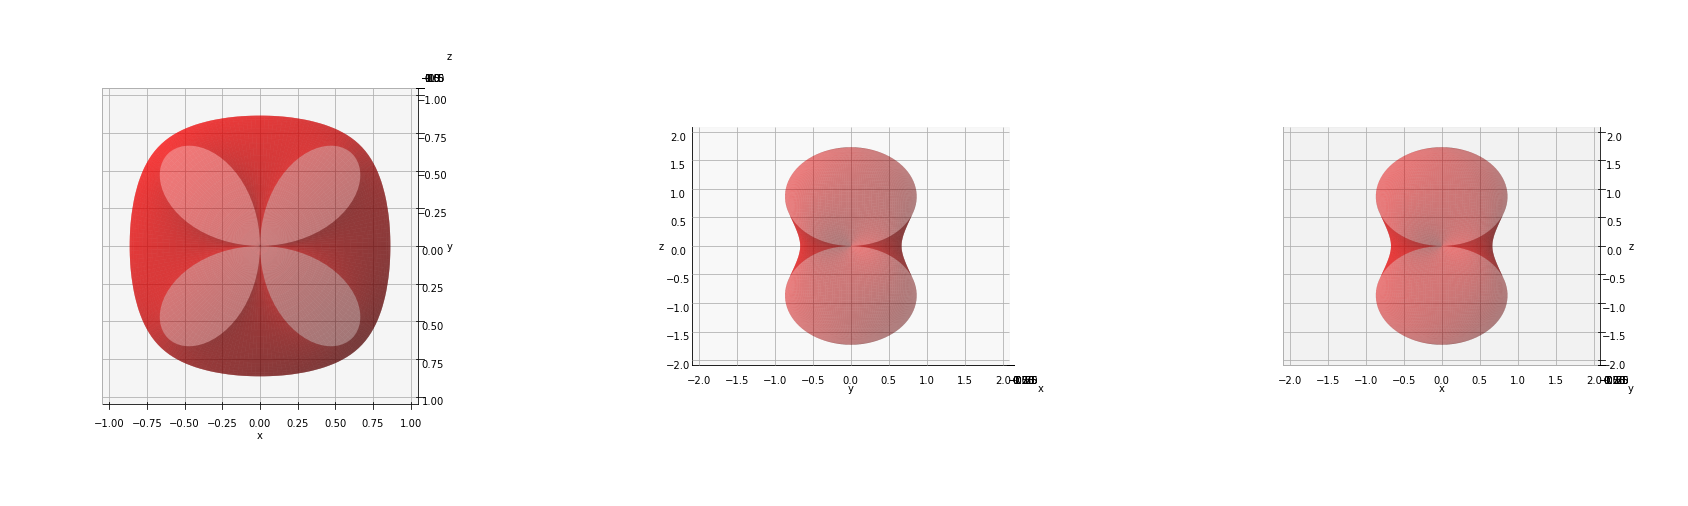

In [12]:

theta, phi = np.linspace(0, np.pi, 91), np.linspace(0, 2*np.pi, 181)

def twoarm( theta, phi, alpha=pi/6):
    return sin(2*alpha)*sqrt( 4*cos(theta)**2*cos(2*phi)**2 + (1+cos(theta)**2)**2*sin(2*phi)**2)

def twoarmpol( theta, phi, chi, alpha=pi/6):
    u = cos(theta)
    return sin(2*alpha)*( (u^2+1)*cos(2*chi)*sin(2*phi)-2*u*sin(2*chi)*cos(2*phi) )

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.view_init(elev=-90, azim=-90)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.01, 1.01)
ax.set_ylim(-1.01, 1.01)
ax.set_proj_type('ortho')


plot = sphericalplot( twoarm, theta, phi, plain=True, axx=ax, rstride=1, cstride=1, color='r',alpha=0.3)

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.view_init(elev=0, azim=-0)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_ylim(-2, 2)
ax2.set_zlim(-2, 2)
ax2.set_proj_type('ortho')

plot = sphericalplot( twoarm, theta, phi, plain=True, axx=ax2, rstride=1, cstride=1, color='r',alpha=0.3)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.view_init(elev=0, azim=-90)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.set_xlim(-2, 2)
ax3.set_zlim(-2, 2)
ax3.set_proj_type('ortho')

plot = sphericalplot( twoarm, theta, phi, plain=True, axx=ax3, rstride=1, cstride=1, color='r',alpha=0.3)

plt.show()

The next plot is from a more "3D" perspective

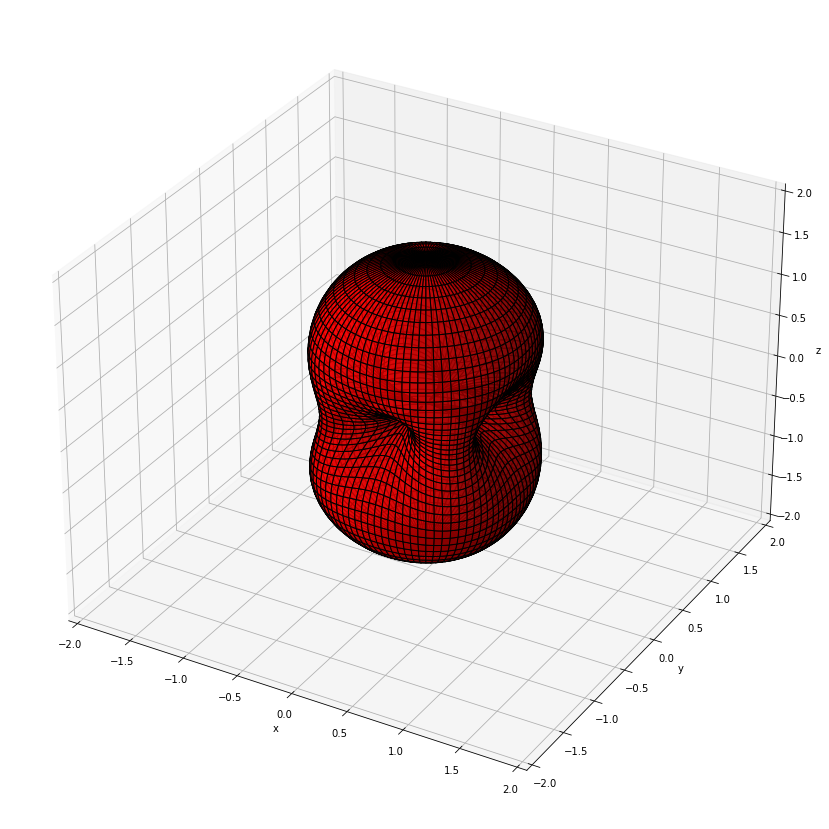

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-2, 2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax3.set_proj_type('ortho')

aplot = sphericalplot( twoarm, theta, phi, plain=True, axx=ax, rstride=2, cstride=2, color='r',edgecolor='k',alpha=0.8)


#ax.plot_surface( sin(THETA) * cos(PHI), sin(THETA) * sin(PHI), ones_like(R)*cos(THETA), color='g', alpha=0.8);

#blob=ax.plot_surface(X, Y, Z, rstride=2, cstride=2, color='r',edgecolor='k',alpha=0.8);


Add a "LISA triangle" and get rid of the axes, so that the plot can be used in a
presentation. Adding the triangle does not really work, as the surface plot covers everything. That needs to be redone with Maya.

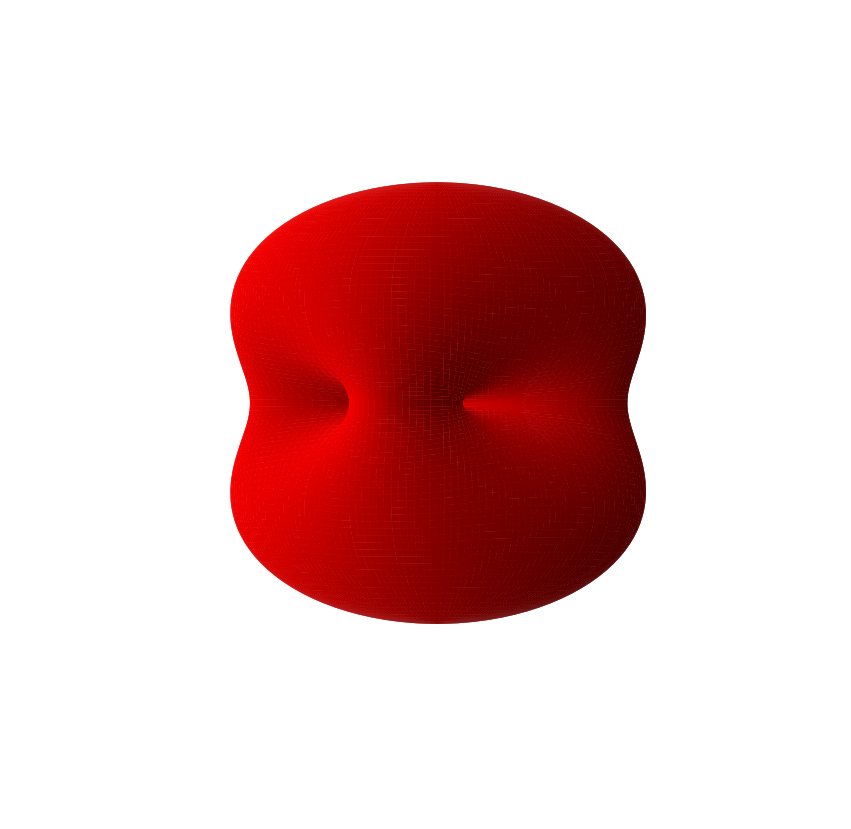

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.view_init(elev=0, azim=-30)
ax.set_xlim(-1.01, 1.01)
ax.set_ylim(-1.01, 1.01)

ax.set_axis_off()

aplot = sphericalplot( twoarm, theta, phi, plain=True, axx=ax, rstride=1, cstride=1, color='r',alpha=1)
alpha = radians(60)
xcoords = [ 2*ii for ii in [cos(alpha), -1, cos(alpha)]]
ycoords = [ 2*ii for ii in [-sin(alpha),0,sin(alpha)]]
zcoords = [0,0,0]
#ax.plot( xcoords, ycoords,zcoords, color='k')

plt.savefig('antennapattern.pdf',format='pdf')


In [13]:
import os 
dir_path = os.path.dirname()
print(dir_path)

TypeError: dirname() missing 1 required positional argument: 'p'

### Tumble the pattern across the orbit

This is just some eye candy:

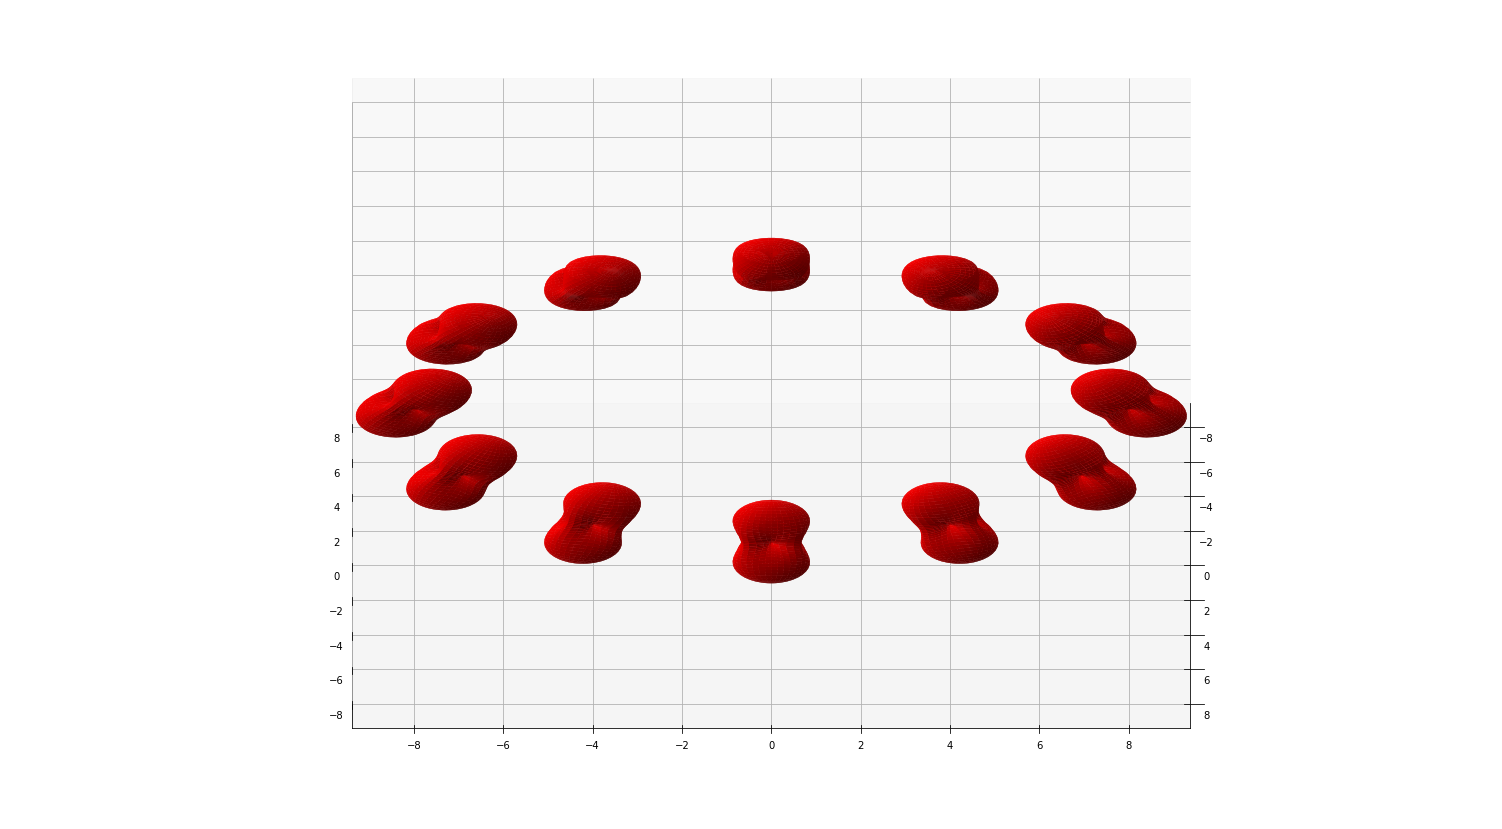

In [22]:
fig = plt.figure(figsize=(16/9*15,15))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_zlim(-9, 9)
ax.set_xlim(-9, 9)
ax.set_ylim(-9, 9)
ax.view_init(elev=45, azim=0)
#ax.set_axis_off()

theta, phi = np.linspace(0, np.pi, 40), np.linspace(0, 2*np.pi, 40)

plot,ax = sphericalplot(twoarm, theta, phi, axx=ax,
                         psi=radians(0), a=88, xi=radians(0),
                         rstride=1, cstride=1,
                         color='r', alpha=1)

for ii in np.arange(0,360,30):
            plot,ax = sphericalplot(twoarm, theta, phi, axx=ax,
                         psi=radians(-ii), a=8, xi=radians(ii),
                         rstride=1, cstride=1,
                         color='r', alpha=1)

#ax.view_init(elev=90, azim=-90)
ax.set_proj_type('ortho')



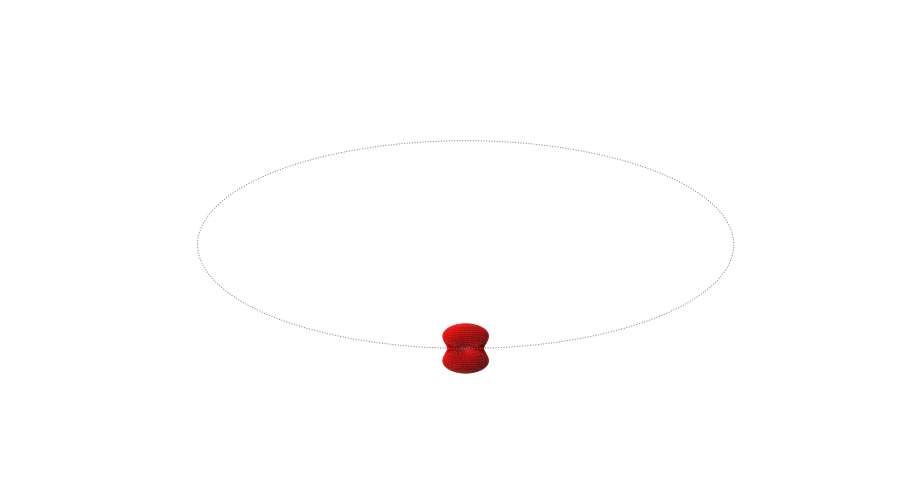

In [26]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Circle, Arrow
import mpl_toolkits.mplot3d.art3d as art3d

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_zlim(-9, 9)
ax.set_xlim(-9, 9)
ax.set_ylim(-9, 9)
ax.set_axis_off()
ax.view_init(elev=45, azim=0)
ax.set_proj_type('ortho')
p = Circle((0, 0), 10, fill=False, linestyle='dotted', color='0.5')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, zdir="z")

frames = 720
def animate(frame):
    
    pl = sphericalplot(twoarm, theta, phi, axx=ax,fig=fig, add=False, 
                         psi=radians(-frame*360/frames), a=10, xi=radians(frame*360/frames),
                         rstride=1, cstride=1,
                         color='r', alpha=0.8)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=16)
HTML(anim.to_html5_video())

Again, but with a color shift

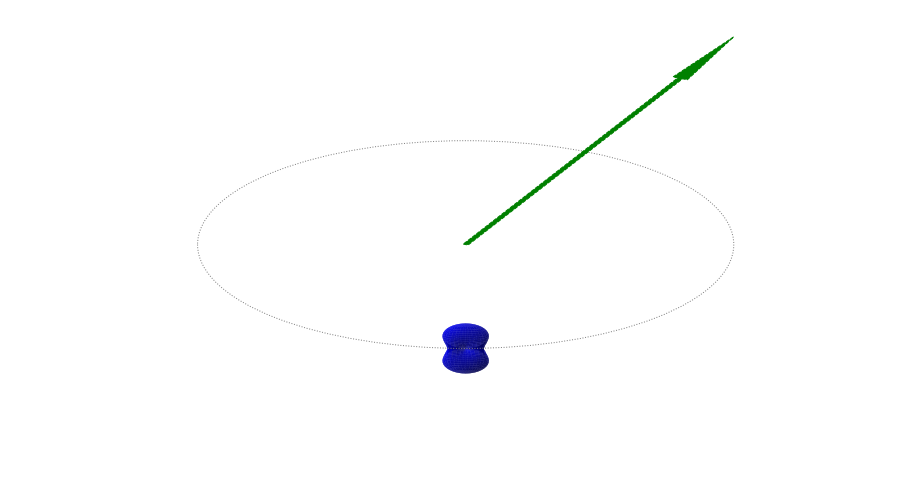

In [29]:
from matplotlib import cm
from matplotlib.patches import Circle, Arrow
import mpl_toolkits.mplot3d.art3d as art3d


fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_zlim(-9, 9)
ax.set_xlim(-9, 9)
ax.set_ylim(-9, 9)
ax.set_axis_off()

ax.view_init(elev=45, azim=0)
ax.set_proj_type('ortho')


p = Circle((0, 0), 10, fill=False, linestyle='dotted', color='0.5')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, zdir="z")
p = Arrow( 0,0, 10,20, linestyle='dashed', color='g')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, zdir="x")

frames = 720
def plotWithSourceDir(frame,ax):
    pl, ax = sphericalplot(twoarm, theta, phi, axx=ax,fig=fig, add=False, 
                         psi=radians(-frame*360/frames), a=10, xi=radians(frame*360/frames),
                         rstride=1, cstride=1,
                         color=cm.jet( 0.5*(1-0.8*cos(2*pi*frame/frames))), alpha=0.8)
    #ax.plot([0,0], [0,10],[0,10], color='g', linestyle='dashed')
    
    return ax
def animate(frame):
    
    plotWithSourceDir(frame,ax)
    plt.pause(.001)
    
    return fig

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=16)
HTML(anim.to_html5_video())

Once again, but without the orbit, just the tumbling. Here you can nicely see that it really just tumbles, no rotation

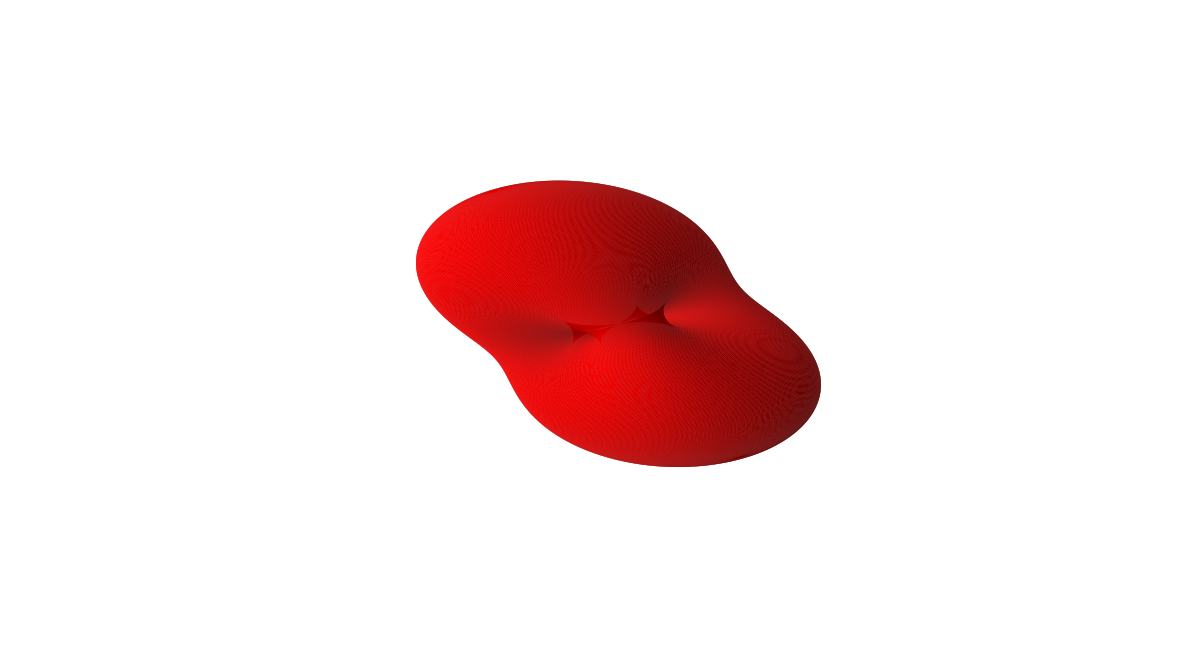

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1536x864', '-pix_fmt', 'rgba', '-r', '62.5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/xv/7kwl39_9355b27y8qhsmm705qcybkc/T/tmpuh2g55j7/temp.m4v']' returned non-zero exit status 255.

In [33]:
fig = plt.figure(figsize=(16/9*12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.set_zlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()
ax.set_proj_type('ortho')

frames = 720
def animate(frame):
    
    pl = sphericalplot(twoarm, theta, phi, axx=ax,fig=fig, add=False, 
                         psi=radians(-frame*360/frames), a=0, xi=radians(frame*360/frames),
                         rstride=1, cstride=1,
                         color='r', alpha=1)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=16)
HTML(anim.to_html5_video())

## Moving detector

The calculations can be found in a mathematica notebook called "triads.nb".

The idea here is to calculate the "trace" of a source with fixed sky coordinates $\Theta$ and $\Phi$ in the coordinate system of the moving detector.

The detectors $z$-axis is tilted by $\kappa\pm30$ degrees away from "solar system north", i.e. the dircetion orthogonal to the ecliptic. The two signs are for the "up pointing" and "down pointing" configurations. As the two configurations might have different effects, we include both here. 

The $y$ axis is tangential to the orbit for a value of $\psi=0$ and the parameter $\psi$ describes a rotation around the $z$-axis of the detector. The $x$ axis completes the right-handed coordinate system, i.e. $\hat e_y\times\hat e_z=\hat e_x$. The solar system coordinate system is denoted by capital letters, i.e. $\hat e_X$, $\hat e_Y$, and $\hat e_Z$, oriented as usual.

The  normal vector of the constellation $\hat e_z$ in the solar system coordinate system is given by 

\begin{equation}
\hat e_z = \begin{pmatrix}
-\epsilon\cos(\pi/3)\cos(\Omega t+\Psi)\\
-\epsilon\cos(\pi/3)\sin(\Omega t + \Psi)\\
\sin(\pi/3)
\end{pmatrix}= 
\frac{1}{2}\begin{pmatrix}
-\epsilon\cos(\Omega t+\Psi)\\
-\epsilon\sin(\Omega t + \Psi)\\
\sqrt{3}
\end{pmatrix}
\end{equation}

The orbital phase $\Psi$ describes the position of the detector at $t=0$, the "orientation flag" distinguishes between the "up" ($\epsilon=1$) and "down" ($\epsilon=-1$) configuration. The $\hat e_x$ and $\hat e_y$ vectors rotate around the $\hat e_z$ axis with a angular velocity of $-\epsilon\Omega$ (the "up" configuration counterrotates, so the angular velocity is $-\Omega$ in that case) and we can pick an initial phase $\xi$ to relate them to some easy to find "fixed" vectors $\hat e_{x_0}$ and $\hat e_{y_0}$.

\begin{align}
\hat e_x &= \cos(-\epsilon\Omega t + \xi) \hat e_{x_0} +  \sin(-\epsilon\Omega t + \xi) \hat e_{y_0}\\
\hat e_y &= -\sin(-\epsilon\Omega t + \xi) \hat e_{x_0} +  \cos(-\epsilon\Omega t + \xi) \hat e_{y_0}
\end{align}

For $\hat e_{y_0}$ we can simply pick the vector tangential to the orbit at the time $t$

\begin{equation}
\hat e_{y_0} = 
\begin{pmatrix}
-\sin(\Omega t+\Psi)\\
\cos(\Omega t + \Psi)\\
0
\end{pmatrix}
\end{equation}

and we can calculate $\hat e_{x_0}$ by evaluating $\hat e_{y_0}\times\hat e_z$

\begin{equation}
\hat e_{x_0} = 
\frac{1}{2}\begin{pmatrix}
\pm\sqrt{3}\cos(\Omega t+\Psi)\\
\pm\sqrt{2}\sin(\Omega t + \Psi)\\
-1
\end{pmatrix}
\end{equation}

Putting things together yields

\begin{align}
\hat e_{x} &= \frac{1}{2}
\begin{pmatrix}
   2 \epsilon \sin (\Omega t ) \sin (\Omega t +\Psi )+\sqrt{3}  \cos (\Omega t ) \cos
   (\Omega t +\Psi )\\
   \sqrt{3}  \cos (\Omega t ) \sin (\Omega t +\Psi )-2 \epsilon \sin (
   \Omega t ) \cos ( \Omega t +\Psi )\\
   \epsilon\cos (\Omega t ) 
\end{pmatrix}\\
\hat e_{y} &= 
 \frac{1}{2}
\begin{pmatrix}
 \sqrt{3} \sin (\Omega t) \cos (\Omega t +\Psi )-2 \cos (\Omega t) \sin(\Omega t +\Psi )\\
 \sqrt{3} \sin (\Omega t) \sin (\Omega t +\Psi )+ 2 \cos (\Omega t ) \cos (\Omega t +\Psi )\\
 \epsilon \sin (\Omega t )
\end{pmatrix}\\
\hat e_{z} &= 
\frac{1}{2}\begin{pmatrix}
-\epsilon\cos(\Omega t+\Psi)\\
-\epsilon\sin(\Omega t + \Psi)\\
\sqrt{3}
\end{pmatrix}
\end{align}

Defining $D$ as a matrix with columns $\hat e_x$, $\hat e_y$, and $\hat e_z$ that transforms from the the detector system ($x,y,z$) to solar system coordinates system ($X,Y,Z$), we get the inverse transfromation from the solar system to the detector system by using the transposed matrix $D^\text{T}$

\begin{align}
D &= \left( \hat e_x| \hat e_y|\hat e_z\right)\\
\vec r_s &= D \vec r_d\\
\vec r_d &= D^\text{T} \vec r_s
\end{align}

Using this relation, we can start with a direction in the solar system coordinate system 
\begin{equation}
  \vec r_s = 
  \begin{pmatrix}
  \sin\Theta\cos\Phi\\
  \sin\Theta\sin\Phi\\
  \cos\Theta
  \end{pmatrix}
\end{equation}

With this, we get for $\vec r_d$, the vector in the detector system
\begin{equation}
\vec r_d = \frac{1}{4}
\begin{pmatrix}
 \sin (\Theta ) \left(\left(\sqrt{3}-2\epsilon\right) \cos (-2 \Omega t +\Phi -\Psi)+
                      \left(\sqrt{3}+2\epsilon\right) \cos (\Phi -\Psi )\right)
 +2 \epsilon \cos (\Theta ) \cos (\Omega t )\\
  \sin (\Theta ) \left(\left(2-\epsilon\sqrt{3}\right) \sin (-2 \Omega t +\Phi -\Psi)+
                      \left(2+\epsilon\sqrt{3}\right) \sin (\Phi -\Psi )\right)
 +2\cos (\Theta ) \sin (\Omega t )\\
   2 \left(\sqrt{3} \cos (\Theta )-\epsilon\sin (\Theta ) \cos (-\Omega  t+\Phi -\Psi)\right)
\end{pmatrix}
\end{equation}
We see that, as expected, only the difference between the angles $\Psi$, denoting the initial position of the constellation on the orbit, and $\Phi$, the source azimuth, as both are measured from the same reference angle. So we can set $\Psi=0$ without any loss of generality. If needed, we can always bring it back by adjusting $\Phi$ accordingly. So with that simplification and some rearranging, we get

\begin{equation}
\vec r_d = \frac{1}{4}
\begin{pmatrix}
 \sin (\Theta ) \left(\left(\sqrt{3}-2\epsilon\right) \cos (2 \Omega t - \Phi)+
                      \left(\sqrt{3}+2\epsilon\right) \cos (\Phi)\right)
 +2 \epsilon \cos (\Theta ) \cos (\Omega t )\\
  \sin (\Theta ) \left(\left(\epsilon\sqrt{3}-2\right) \sin (2 \Omega t -\Phi)+
                      \left(\epsilon\sqrt{3}+2\right) \sin (\Phi)\right)
 +2\cos (\Theta ) \sin (\Omega t )\\
   2 \left(\sqrt{3} \cos (\Theta )-\epsilon\sin (\Theta ) \cos (\Omega  t-\Phi)\right)
\end{pmatrix}
\end{equation}

As $|\vec r_d|=1$, as it should, we can simply read off the expressions for $\phi$ and $\theta$, the directional angles in the detector system as functions of the directions $\Phi$ and $\Theta$:

\begin{align}
 \tan\phi &=\frac{\sin (\Theta ) \left(\left(\epsilon\sqrt{3}-2\right) \sin (2 \Omega t -\Phi)+
                      \left(\epsilon\sqrt{3}+2\right) \sin (\Phi)\right)
 +2\cos (\Theta ) \sin (\Omega t )}{\sin (\Theta ) \left(\left(\sqrt{3}-2\epsilon\right) \cos (2 \Omega t - \Phi)+
                      \left(\sqrt{3}+2\epsilon\right) \cos (\Phi)\right)
 +2 \epsilon \cos (\Theta ) \cos (\Omega t )}
 \\
 \cos\theta &= \frac{1}{2} \left(\sqrt{3} \cos (\Theta )-\epsilon\sin (\Theta ) \cos (\Omega  t-\Phi)\right)
\end{align}

### Helper function: The path of a source in the frame of the constellation

In [38]:
def pathOfSource(Theta, Phi, plain=True, xi=0, a=0, e=1, tau=[]):
    """
    Calculates the path of the source in the detector system for one orbital period (i.e. one year)

    Parameters
    ----------

    Theta     : Theta-coordinate of the source in solar system coordinates
    xi        : Initial orientation of the constellation
    e         : Tilt of the constellation: e=+1 is up, e=-1 is down
    tau       : orbital parameter. If not set, 0 to 2pi will be taken
    plain     : Defaults to True. If false, the path will be plot on the tumbling pattern.
                In this case, xi and a need to be set as well
    a         : orbital radius
    xi        : orbital phase

    """
    
    
    if len(tau)==0:
        tau = np.linspace(0, 2 * np.pi, 100)

    psi= -e*xi
    
    # calculate the path 
    x = 1/4*sin(Theta)*( (sqrt(3)-2*e)*cos(2*tau-Phi)+(sqrt(3)+2*e)*cos(Phi)) + 1/2*e*cos(Theta)*cos(tau)
    
    y = 1/4*sin(Theta)*( (e*sqrt(3)-2)*sin(2*tau-Phi)+(e*sqrt(3)+2)*sin(Phi)) + 1/2*cos(Theta)*sin(tau)
    
    z = 1/2*(sqrt(3)*cos(Theta) - e*sin(Theta)*cos(tau-Phi))
    
    

    # get the two angles now in the detector system
    phi = arctan2(y, x)
    theta = arccos(z)

    # this is the easiest way
    r  = twoarm(theta,phi)
    rx = r*x
    ry = r*y
    rz = r*z

    # take care of the orbital motion, if needed
    if not plain:
        rx,ry,rz = toOrbit(rx,ry,rz,psi=psi,a=a,xi=xi)
        
    return rx, ry, rz,r, phi, theta, tau

Run some tests. Plot the "plain" wireframe and add some traces

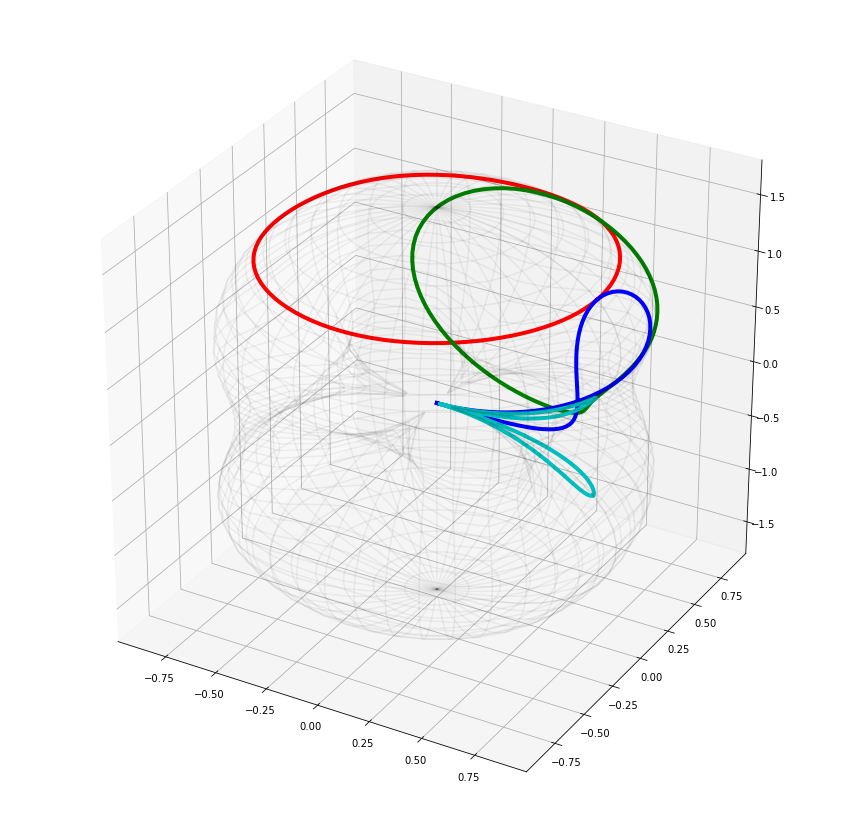

In [39]:
fig=plt.figure(figsize=(15, 15))
ax=fig.gca(projection='3d')

nwf= 40;
theta, phi = np.linspace(0, np.pi, nwf), np.linspace(0, 2*np.pi, nwf)

plot, ax = sphericalplot( twoarm, theta, phi, \
                          plain=True, psi=psi, xi=xi,a=0,\
                          add=True,kind='wireframe',\
                          axx=ax, rstride=1, cstride=1, \
                         color='r', edgecolor='k',alpha=0.05 )

Theta = 0
Phi = 0
e = 1
# calculate the path of the source on the antenna pattern in the constellation system
rx, ry, rz, r, PHI, THETA, tau = pathOfSource( radians(Theta), radians(Phi), plain=True, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, 2*pi, 100))

ax.plot(rx,ry,rz, 
        label='phi={} Degree, theta={} Degree'.format(Phi, Theta), color='r', linewidth=4)

Theta = 30
rx, ry, rz, r, PHI, THETA, tau = pathOfSource( radians(Theta), radians(Phi), plain=True, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, 2*pi, 100))
ax.plot(rx,ry,rz, 
        label='phi={} Degree, theta={} Degree'.format(Phi, Theta), color='g', linewidth=4)

Theta = 60
rx, ry, rz, r, PHI, THETA, tau = pathOfSource( radians(Theta), radians(Phi), plain=True, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, 2*pi, 100))
ax.plot(rx,ry,rz, 
        label='phi={} Degree, theta={} Degree'.format(Phi, Theta), color='b', linewidth=4)

Theta = 90
rx, ry, rz, r, PHI, THETA, tau = pathOfSource( radians(Theta), radians(Phi), plain=True, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, 2*pi, 100))
ax.plot(rx,ry,rz, 
        label='phi={} Degree, theta={} Degree'.format(Phi, Theta), color='c', linewidth=4)

Good. Let's animate that

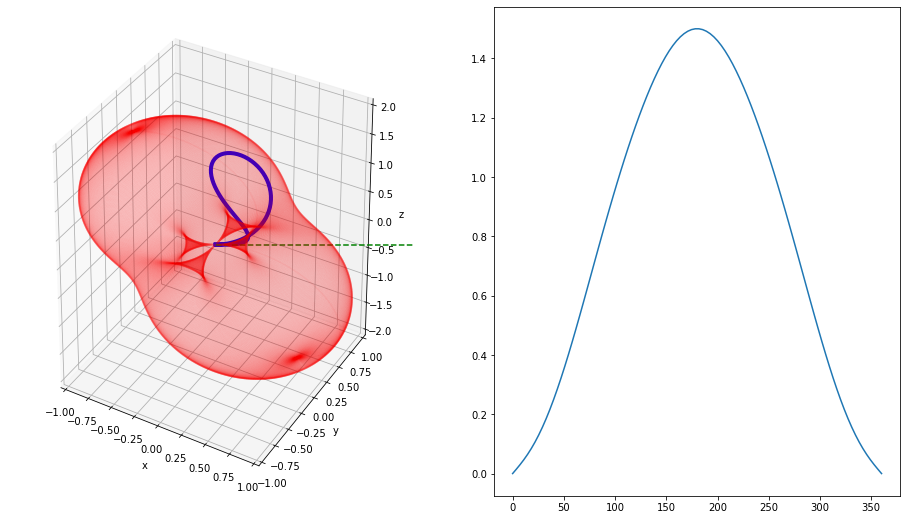

In [40]:
# Theta and Phi are the directions in solar system
Theta = 60
Phi = 0
e = 1

# psi and xi describe the inital position of the constellation
xi = 360
psi =-e*xi


fig=plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 2, 1, projection='3d')
#ax.view_init(azim=Phi, elev=Theta)


# make a lot of wireframe 
nwf= 40;
theta, phi = np.linspace(0, np.pi, 400), np.linspace(0, 2*np.pi, 400)

# a short helper function to combine the plots

def plotAntennaAndTrack(f, theta, phi, Theta, Phi, xi=0, e=1,ax=0, a=0):
    psi=-e*xi
 
    # calculate the path of the source on the antenna pattern in the constellation system
    rx, ry, rz, r, PHI, THETA, tau = pathOfSource( Theta, Phi, plain=False, xi=xi,a=a,e=1,\
                                             tau=np.linspace(0, xi, 100))

    #x,y,z = toOrbit(rx,ry,rz,psi=psi, a=a, xi=xi)
    ax.collections=[]
    ax.lines=[]
    ax.plot(rx,ry,rz, 
        label='phi={} Degree, theta={} Degree'.format(Phi, Theta), color='b', linewidth=4)
    
    # aux line
    starR=5
    ax.plot( [0 ,starR*sin(Theta)*cos(Phi)],[0, starR*sin(Theta)*sin(Phi)],[0, starR*cos(Theta)], color='g', linestyle='dashed')
    ax.plot( [0 ,r[-1]*sin(Theta)*cos(Phi)],[0, r[-1]*sin(Theta)*sin(Phi)],[0, r[-1]*cos(Theta)], color='g', linewidth=4)
    plot, ax = sphericalplot( f, theta, phi, \
                          plain=False, psi=psi, xi=xi,a=a,\
                          add=True,kind='wireframe',\
                          axx=ax, rstride=1, cstride=1, \
                         color='r', edgecolor='r',alpha=0.05 )
    
    #print( vars(ax))
   
    return ax, r, tau
    
ax,r,t = plotAntennaAndTrack( twoarm, theta, phi, radians(Theta), radians(Phi), xi=radians(xi),e=e, ax=ax)

# switch off the legend and the axes
#ax.legend()
#ax.set_axis_off()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
bbox=1.01
ax.set_xlim(-bbox, bbox)
ax.set_ylim(-bbox, bbox)
ax.set_zlim(-2*bbox, 2*bbox)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(180/pi*t,r)



#plt.show()

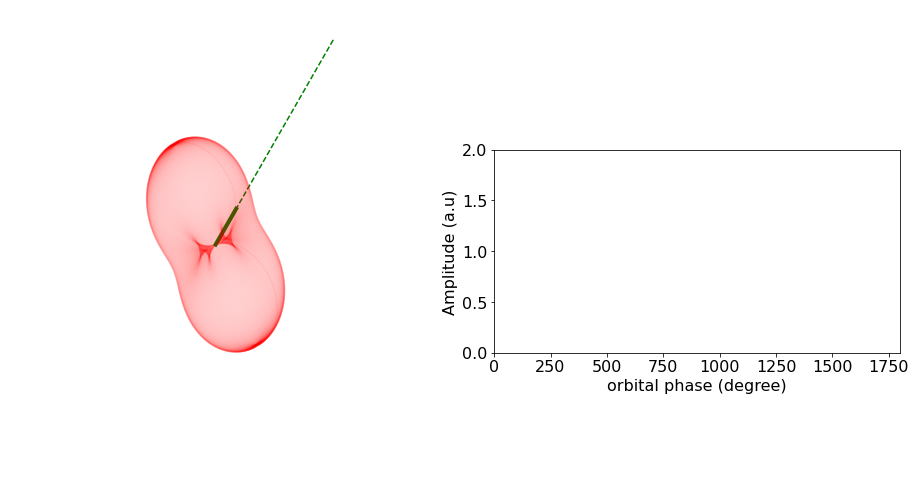

In [41]:
fig=plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'font.family': 'sans-serif'})

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()
ax.set_proj_type('ortho')

years=5
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(0, years*360)
ax2.set_ylim(0,2)
ax2.set_xlabel("orbital phase (degree)")
ax2.set_ylabel("Amplitude (a.u)")

Theta=30
Phi=0
e=1



# make a lot of wireframe 
nwf= 200;
theta, phi = np.linspace(0, np.pi, nwf), np.linspace(0, 2*np.pi, nwf)

frames = years*24

_,_,_,r1, _,_ ,t1 = pathOfSource( radians(Theta), radians(Phi), plain=False, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, years*2*pi, frames))


def animate(frame):
    
    _,r,t = plotAntennaAndTrack( twoarm, theta, phi, radians(Theta), radians(Phi), xi=radians(frame*years*360/frames),e=e, ax=ax)
   
    
    #print(r)
    ax2.lists=[]
    ax2.set_aspect(0.5*years*360/2)
    ax2.plot( 180/pi*t, r, color='r')
    ax2.plot( 180/pi*t, r*sin(10*t), color='b')
    
    plt.pause(.001)
    
    return fig



anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
HTML(anim.to_html5_video()) 

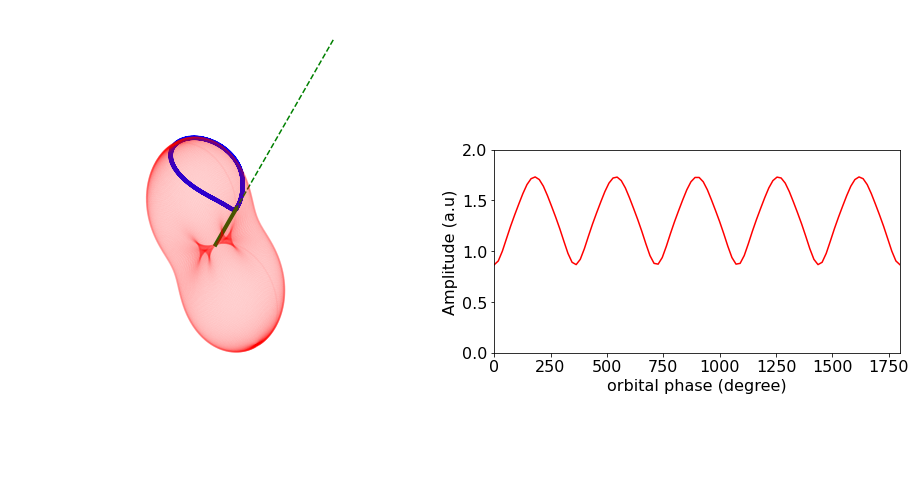

In [47]:
fig=plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'font.family': 'sans-serif'})

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()
ax.set_proj_type('ortho')

years=5
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(0, years*360)
ax2.set_ylim(0,2)
ax2.set_xlabel("orbital phase (degree)")
ax2.set_ylabel("Amplitude (a.u)")

_,r,t = plotAntennaAndTrack( twoarm, theta, phi, radians(Theta), radians(Phi), xi=radians(years*360),e=e, ax=ax)
ax2.lists=[]
ax2.set_aspect(0.5*years*360/2)
ax2.plot( 180/pi*t, r, color='r')


plt.savefig('AM_pos1.pdf', format='pdf')

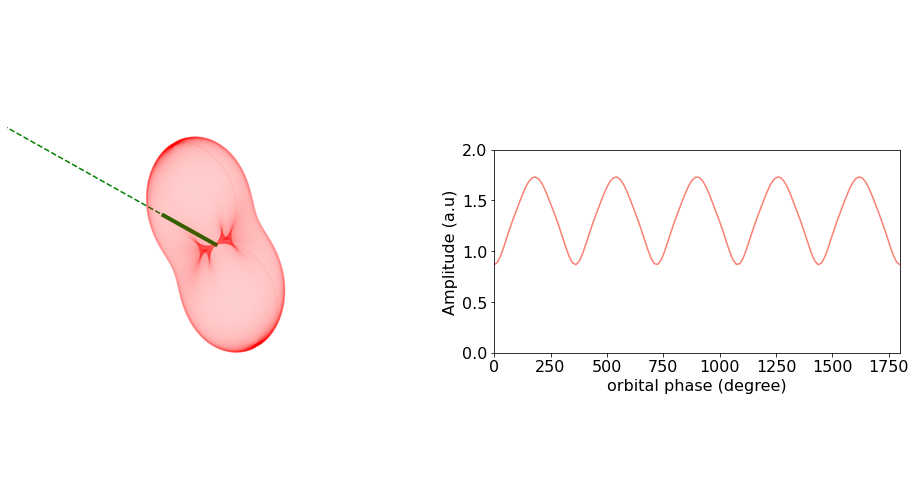

In [327]:
fig=plt.figure(figsize=(16, 9))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim(-2, 2)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_axis_off()
ax.set_proj_type('ortho')

years=5
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(0, years*360)
ax2.set_ylim(0,2)
ax2.set_xlabel("orbital phase (degree)")
ax2.set_ylabel("Amplitude (a.u)")


Theta=80
Phi=180
e=1

# make a lot of wireframe 
nwf= 200;
theta, phi = np.linspace(0, np.pi, nwf), np.linspace(0, 2*np.pi, nwf)

frames = years*24

_,_,_,r2, _,_ ,t2 = pathOfSource( radians(Theta), radians(Phi), plain=False, xi=0,a=0,e=1,\
                                             tau=np.linspace(0, years*2*pi, frames))

def animate(frame):
    
    _,r,t = plotAntennaAndTrack( twoarm, theta, phi, radians(Theta), radians(Phi), xi=radians(frame*years*360/frames),e=e, ax=ax)
   
    
    #print(r)
    ax2.lists=[]
    ax2.set_aspect(0.5*years*360/2)
    ax2.plot( 180/pi*t1, r1, color='salmon')
    ax2.plot( 180/pi*t, r, color='r')
    #ax2.plot( 180/pi*t, r*sin(10*t), color='b')
    
    plt.pause(.001)
    
    return fig



anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
HTML(anim.to_html5_video())

NameError: name 'tau' is not defined

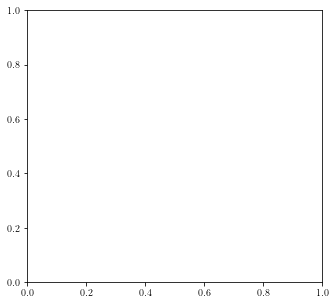

In [46]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(1, 3, 1)
ax.plot(tau*180/pi, r)
ax.set_xlabel('orbital phase')
ax.set_ylabel('R')
ax = fig.add_subplot(1, 3, 2)
ax.plot(tau*180/pi, PHI*180/pi)
ax.set_xlabel('orbital phase')
ax.set_ylabel('$\phi$')
ax = fig.add_subplot(1, 3, 3)
ax.plot(tau*180/pi, THETA*180/pi)
ax.set_xlabel('orbital phase')
ax.set_ylabel(r'$\theta$')

Ok, let's define a couple of functions that gives us the 'effective' signal for a given position on the sky in solar system coordinates

In [62]:
def DetectorPosFromSkyPos(Theta, Phi, xi=0, Psi=0, up=True ):
    
    if up:
        e=1
    else:
        e=-1
        
    rx, ry, rz, r, phi, theta, tau = pathOfSource( Theta, Phi, Psi, xi, e)
    #tau = np.linspace(0, 2 * np.pi, 100)
    
    
    #x = 1/4*( sin(Theta)*(-(2-e*sqrt(3))*cos(xi+Phi-Psi-(1+e)*tau)+(2+e*sqrt(3))*cos(xi-Phi+Psi+(1-e)*tau)) - 2*cos(Theta)*cos(xi-e*tau))
    #y = 1/4*( sin(Theta)*( (2-e*sqrt(3))*sin(xi+Phi-Psi-(1+e)*tau)-(2+e*sqrt(3))*sin(xi-Phi+Psi+(1-e)*tau)) + 2*cos(Theta)*sin(xi-e*tau))
    #z = 1/2*( sin(Theta)*cos(Phi-Psi-tau)+ e*sqrt(3)*cos(Theta))

    ## get the angles
    #phi = arctan2(y,x)
    #theta = arccos(z)
    
    return phi,theta, tau
    
    
def SignalFromSkyPos( Theta, Phi, xi=0, Psi=0, up=True ):
   
    
    (PHI, THETA, tau)= DetectorPosFromSkyPos( Theta, Phi, xi, Psi, up)
    dtau = (tau[1]-tau[0])
    Tau = (tau[-1]-tau[0])
    
    r = sin(2*alpha)*sqrt( 4*cos(THETA)**2*cos(2*PHI)**2 + (1+cos(THETA)**2)**2*sin(2*PHI)**2)
    
    return sum(r)*dtau/Tau



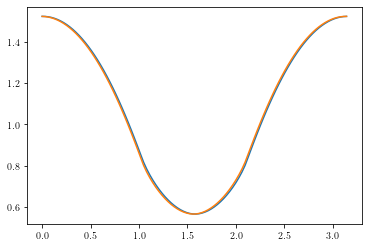

In [63]:
qq = linspace(0,pi,100)
raveup = [SignalFromSkyPos( q, 0, up=True ) for q in qq]
ravedown = [SignalFromSkyPos( q, 0, up=False ) for q in qq]
plt.plot( qq,raveup, qq,ravedown)

Let's see if we can make a map of the average signal over the solar system coordinates. Use healpix gor this, as it allows to easily grid up a sphere.

In [48]:
import healpy as hp

ModuleNotFoundError: No module named 'healpy'

In [61]:
NSIDE = 32
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

Approximate resolution at NSIDE 32 is 1.8 deg
12288


In [75]:
m = zeros(NPIX)
for k in arange(NPIX):
    theta,phi= hp.pix2ang(NSIDE, k)
    m[k]= SignalFromSkyPos(phi,theta, xi=0, up=True)/sqrt(6/5)

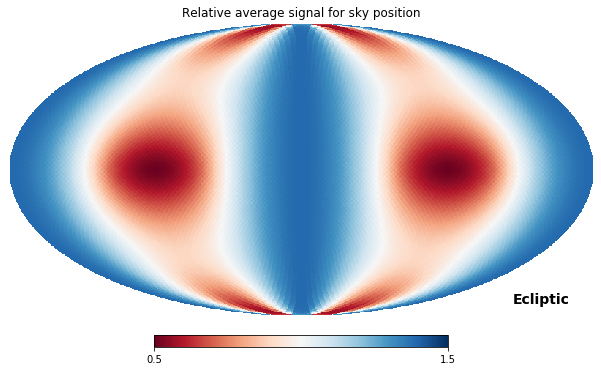

In [80]:
hp.mollview(m, title="Relative average signal for sky position", cmap=plt.get_cmap("RdBu"), min=0.5,max=1.5, coord='E')

Now do the same for (RA,DEC) - we use astropy for this.

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord

ModuleNotFoundError: No module named 'astropy'

In [175]:
m = zeros(NPIX)
coords = np.array([hp.pix2ang(NSIDE,k, lonlat=True) for k in arange(NPIX)]).transpose()
c=SkyCoord(coords[0], coords[1], unit='deg', frame='icrs')

for k in arange(NPIX):
   # theta,phi= hp.pix2ang(NSIDE, k)
   # c = SkyCoord(ra=phi, dec=pi/2-theta, frame='icrs', unit='rad')
    m[k]= SignalFromSkyPos(c[k].barycentricmeanecliptic.lon.value*pi/180,c[k].barycentricmeanecliptic.lat.value*pi/180, xi=0, up=True)/sqrt(6/5)
    
    

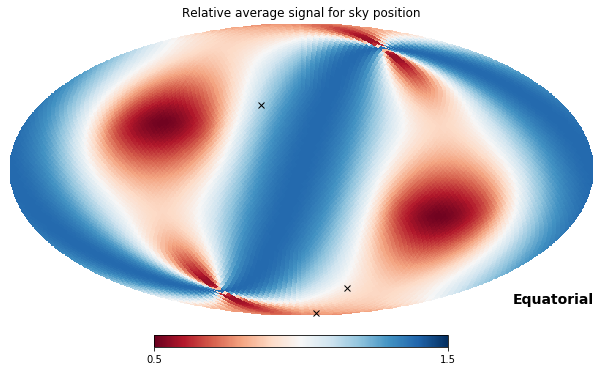

In [176]:
hp.mollview(m, title="Relative average signal for sky position", cmap=plt.get_cmap("RdBu"), min=0.5,max=1.5, coord='C')
for kk in ("M31", "LMC", "SMC"):
    c=SkyCoord.from_name(kk)
    hp.projplot(pi/2-c.barycentricmeanecliptic.data.lat.value,c.barycentricmeanecliptic.data.lon.value, 'kx')    # idem but with blue 'x'
#hp.projplot(90*pi/180,0*pi/180, 'kx') 
#hp.projplot(0.48,0.58, 'kx')

In [189]:
m = zeros(NPIX)
coords = np.array([hp.pix2ang(NSIDE,k, lonlat=True) for k in arange(NPIX)]).transpose()
c=SkyCoord(coords[0], coords[1], unit='deg', frame='galactic')

for k in arange(NPIX):
   # theta,phi= hp.pix2ang(NSIDE, k)
   # c = SkyCoord(ra=phi, dec=pi/2-theta, frame='icrs', unit='rad')
    m[k]= SignalFromSkyPos(c[k].barycentricmeanecliptic.lon.value*pi/180,c[k].barycentricmeanecliptic.lat.value*pi/180, xi=pi/6, up=True)/sqrt(6/5)
    
    

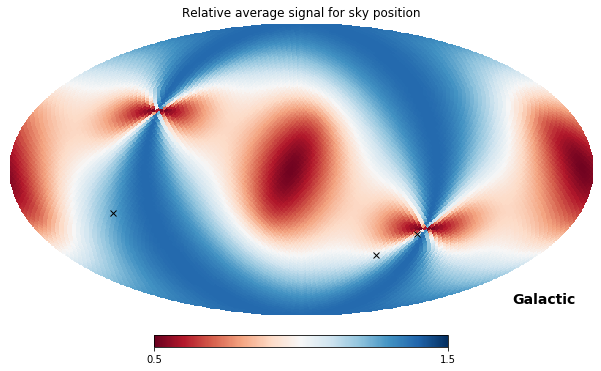

In [188]:
hp.mollview(m, title="Relative average signal for sky position", cmap=plt.get_cmap("RdBu"), min=0.5,max=1.5, coord='G')
for kk in ("M31", "LMC", "SMC"):
    c=SkyCoord.from_name(kk)
    hp.projplot(pi/2-c.galactic.data.lat.value,c.galactic.data.lon.value, 'kx')    # idem but with blue 'x'

In [1]:
SkyCoord.from_Name('galactic center')

NameError: name 'SkyCoord' is not defined

In [185]:
SkyCoord(coords[0], coords[1], unit='deg', frame='galactic')

<SkyCoord (Galactic): (l, b) in deg
    [( 45.,  88.53802884), (135.,  88.53802884), (225.,  88.53802884), ...,
     (135., -88.53802884), (225., -88.53802884), (315., -88.53802884)]>

In [167]:
coords = np.array([hp.pix2ang(NSIDE,k, lonlat=True) for k in arange(NPIX)]).transpose()

In [173]:
c=SkyCoord(coords[0], coords[1], unit='deg', frame='icrs')

In [174]:
c.barycentricmeanecliptic.lon.value*pi/180

array([1.52726801, 1.61432427, 1.61809993, ..., 4.66508495, 4.66886066,
       4.75591692])

In [159]:
SignalFromSkyPos(c.barycentricmeanecliptic.data.lon.value,c.barycentricmeanecliptic.data.lat.value, xi=0, up=True)/sqrt(6/5)

1.0454400155038053

In [151]:
c.barycentricmeanecliptic.lat.value

33.34860635930612

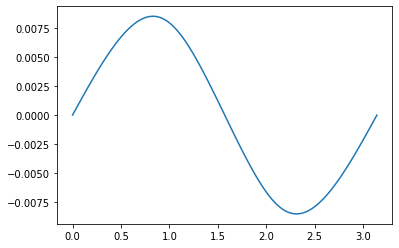

In [42]:
plt.plot( qq,[SignalFromSkyPos( q, pi/6, up=True ) - SignalFromSkyPos( q, pi/6, up=False ) for q in qq])

In [31]:
(p,q,t) = DetectorPosFromSkyPos( pi/3,pi/6, up=True)

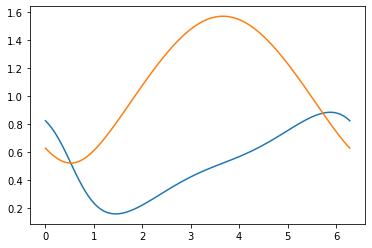

In [32]:
plt.plot(t,p, t, q)

In [34]:
SignalFromSkyPos( pi/3, pi/6, up=False)

1.0359508835690965